In [1]:
import datetime as dt

import calendar

import numpy as np

import pandas as pd

import plotly.express as px

import plotly.graph_objects as go

import plotly.io as pio

In [2]:
pd.options.plotting.backend = 'plotly'
pio.templates.default = 'plotly_white'

In [3]:
figsize = dict(width=950, height=400)

# Hydro production forecast model

## Overview of the data

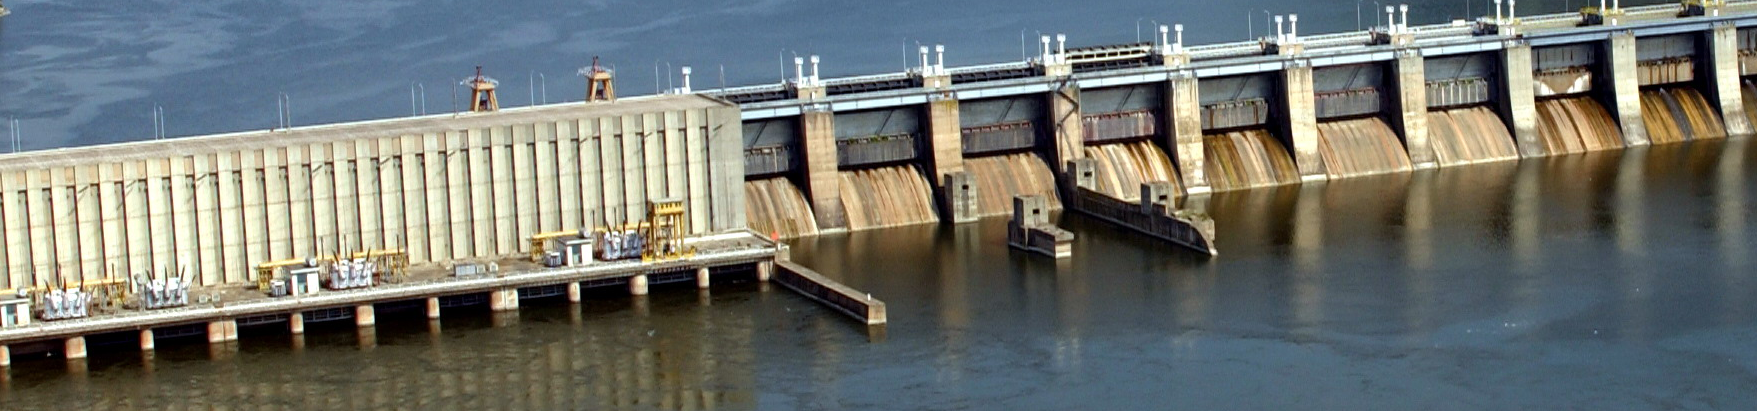

Data for production of the __Iron Gate__ power plant is given.

Preliminary review of the data reveals quite a lot of NaN values. Cells are renamed for easier handling.

In [4]:
df = pd.read_excel('Hydro.xlsx', engine='openpyxl', index_col='Date')
df.index = pd.to_datetime(df.index)
df

River Flow [m^3/s]  Production [MWh/daily]
Date                                                  
2015-02-12              7100.0                 19802.0
2015-02-13              6800.0                 20336.0
2015-02-14              6700.0                 18313.0
2015-02-15              6600.0                 17703.0
2015-02-16              6500.0                 18396.0
...                        ...                     ...
2017-12-27              7700.0                     NaN
2017-12-28              7600.0                     NaN
2017-12-29              7450.0                     NaN
2017-12-30              7300.0                     NaN
2017-12-31              7200.0                     NaN

[1054 rows x 2 columns]

In [5]:
df.columns = ['flow', 'production']

Some plots are drawn to be able to better understand the data. Over time and correlation of flow vs production which will be of interest for forecasting.

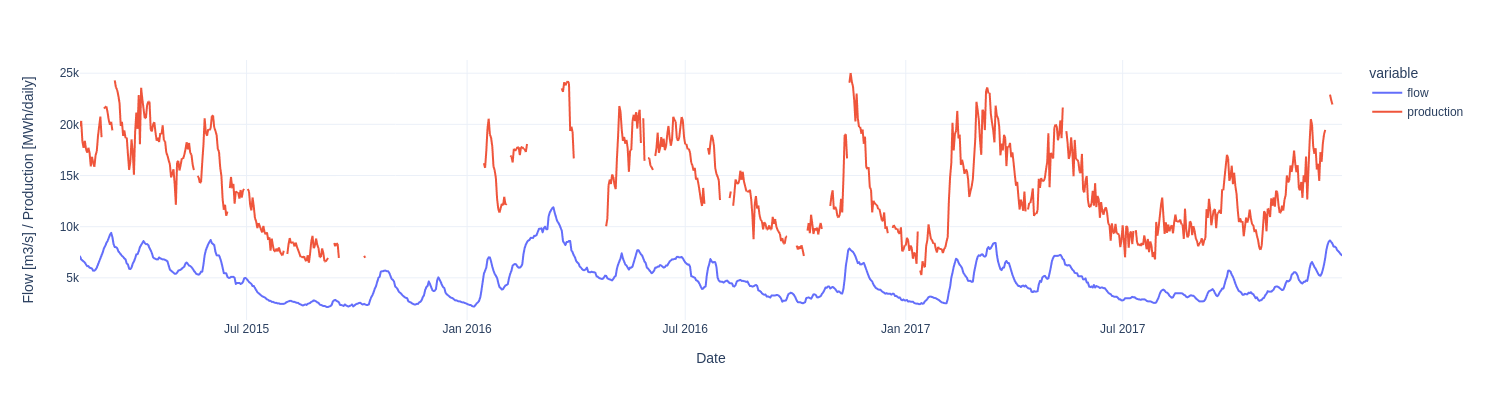

In [6]:
fig = px.line(df)
fig.update_layout(xaxis_title='Date', yaxis_title='Flow [m3/s] / Production [MWh/daily]', **figsize)

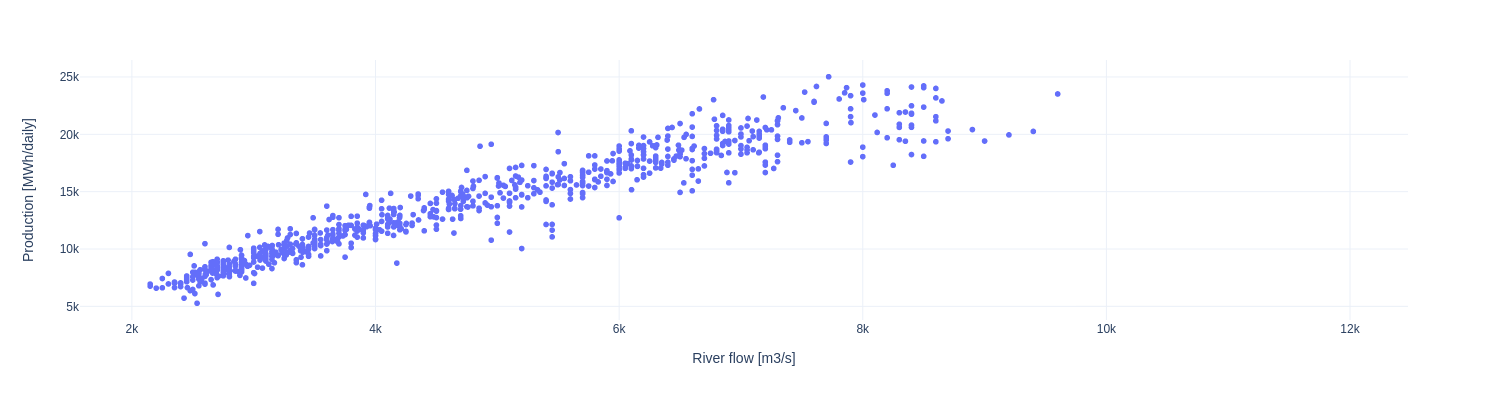

In [7]:
fig = px.scatter(df, x='flow', y='production')

fig.update_layout(xaxis_title='River flow [m3/s]', yaxis_title='Production [MWh/daily]', **figsize)
fig.show()

## Point A & B

_Build a model in form of $y = f(x) = k x + n$ that approximates the data, where $x$ is river flow in m3/s and $y$ is realized daily production._

_Can you develop a non-linear model that would better describe the relationship between river flow and energy production?_

A linear model is fitted to the data using numpy polyfit, which does least squares approximation in the background. It can also be used for higher order polynomials, so 3 models are generated right away, linear, quadratic and cubic.

Null values are removed first, then models are generated and residuals are obtained also. The selection of the best model will not be done solely on residuals, we are looking that the shape of the model makes physical sense.

In [8]:
df_not_null = df[~df.production.isnull()]
df_null = df[df.production.isnull()]

In [9]:
approximation_1 = np.polyfit(df_not_null.flow, df_not_null.production, deg=1, full=True)
poly_1 = np.poly1d(approximation_1[0])

approximation_2 = np.polyfit(df_not_null.flow, df_not_null.production, deg=2, full=True)
poly_2 = np.poly1d(approximation_2[0])

approximation_3 = np.polyfit(df_not_null.flow, df_not_null.production, deg=3, full=True)
poly_3 = np.poly1d(approximation_3[0])

Coefficients for each model, $n$ and $k$ respectively.

In [10]:
approximation_1[0], approximation_2[0], approximation_3[0]

(array([   2.48406769, 1935.08540128]),
 array([-1.71022393e-04,  4.26086311e+00, -2.13796871e+03]),
 array([-2.24937559e-08,  1.97574549e-04,  2.38791502e+00,  7.63083370e+02]))

$f_1(x) = 2.484 x + 1935$

$f_2(x) = -1.710 \times 10^{-4} x^2 + 4.261 x - 2.138 \times 10^3$

$f_3(x) = -2.249 \times 10^{-8} x^3 + 1.976 \times 10^{-4} + 2.388 x + 763083$

Residuals for each approximation/model.

In [11]:
approximation_1[1], approximation_2[1], approximation_3[1]

(array([1.45944396e+09]), array([1.25067153e+09]), array([1.2383636e+09]))

All models are plotted with the data.

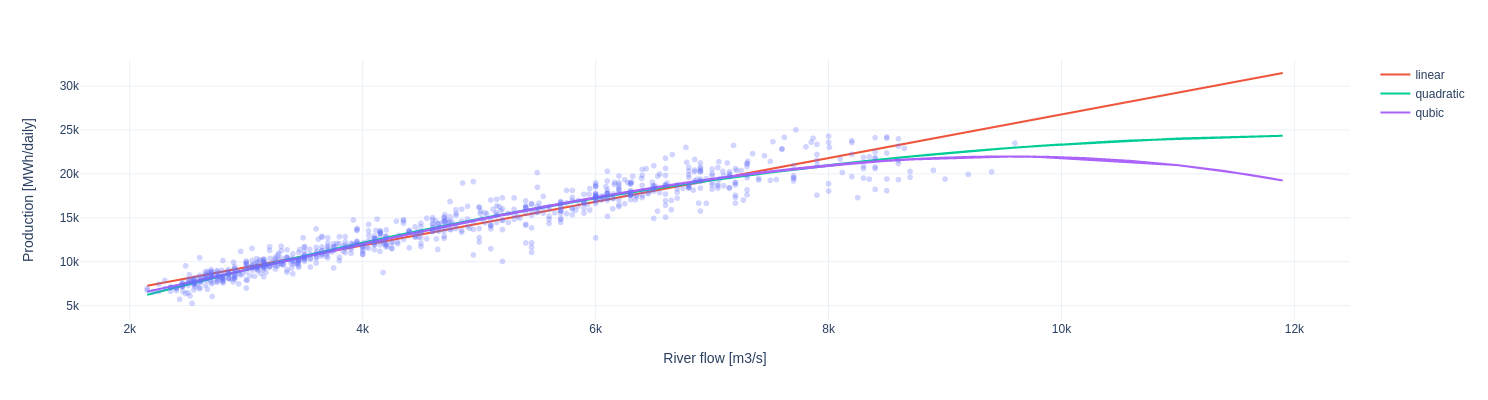

In [12]:
fig = px.scatter(df, x='flow', y='production', opacity=0.3)

fig.add_scatter(x=df.flow, y=poly_1(df.flow), name='linear')
fig.add_scatter(x=df.flow, y=poly_2(df.flow), name='quadratic')
fig.add_scatter(x=df.flow, y=poly_3(df.flow), name='qubic')


fig.update_layout(xaxis_title='River flow [m3/s]', yaxis_title='Production [MWh/daily]', **figsize)

It seems that both quad and cube approximation fit the data better. To pick the best two additional points are investigated.

1) How does the model predict the missing data?

Mostly the models estimate similar production, except for the flow peak in March. It is clear that cubic model has a problem at very high flow where the production drops sharply. On the other hand the linear model probably predicts excesive production as it assumes there is no limit to how much energy can be produced. Quadratic model therefore seems the best fit according to which there would be an upper limit of around 25k MWh of daily production.

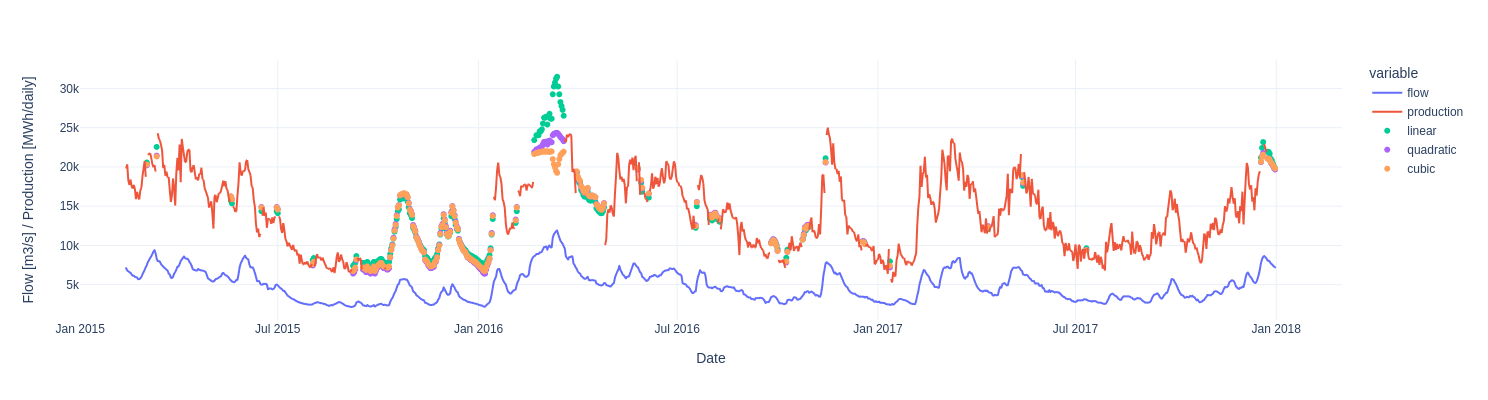

In [13]:
fig = px.line(df)

fig.add_scatter(x=df_null.index, y=poly_1(df_null.flow), mode='markers', name='linear')
fig.add_scatter(x=df_null.index, y=poly_2(df_null.flow), mode='markers', name='quadratic')
fig.add_scatter(x=df_null.index, y=poly_3(df_null.flow), mode='markers', name='cubic')

fig.update_layout(xaxis_title='Date', yaxis_title='Flow [m3/s] / Production [MWh/daily]', **figsize)

2) Which model agrees best with the physical model of the powerplant?

The plant is rated for [1026 MW](https://web.archive.org/web/20090813183115/http://www.djerdap.rs/index.aspx?pageno=14&mId=177&mpId=69) which would translate to a daily maximum of 24624 MWh, assuming the found data is still correct. This would confirm the suitability of quadratic model as it tapers off at that point.

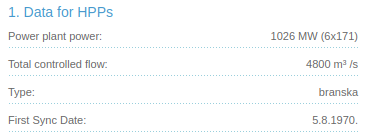

## Point C

_Hydro production model has now been built on historical data of measured/realized river flow. Think about a daily forecasting process, what would an analyst need to forecast daily energy production for a few days ahead? Which data would be needed and how would you get it? Present your idea in a short paragraph._

Flow needs to be predicted as accurately as possible to be able to then predict the energy production in the future. So every data that affects the flow should be gathered and fed to a flow model.

Past, realtime and forecasted __weather data__ would need to be gathered and parsed, such as rainfall and other relevant conditions, which can usually be obtained from local meteorological institutions. Flow at __upstream dams__ which can probably vary would need to be obtained and if possible future plans of the operators of those dam would be useful. __Statistical models__ could be used for seasonal effects but those probably wouldn't hold much value for short-term forecast.

To build a model past data of mentioned effects would be gathered and checked for correlation with the river flow. Old data would be used to fit a model, similar to the production forecast. In this case it would be multivariate but would in essence follow the same math. For example, rainfal in different locations and at different times would take values of $x_i$ and flow for the desired forecast time $y_i$. Through matrix inverse $k_i$ would then be found. The size/scope of locations and relevant times would be determined through analysis of correlation and general data analysis.

This would be a good model to start through which the data and flow itself would be better understood. It would set foundation for more complex models. A very good place to start would also be to review the state-of-art on this subject, maybe some good models or approaches are already available.

## Point D

_There are various factors that affect electricity prices on wholesale exchanges. Apart of hydro production, what are, in your opinion, those factors that are influencing electricity prices on a daily basis?_

On the side of supply I would expect fluctuations in production also for other renewable generation, such as solar and wind. Both are very sensitive to weather conditions and fluctuate daily.

I would expect battery and other types of energy storage to play a role but I think they also have potential to reduce the fluctuations. I'd say that unplanned failure or maintainance at certain plants can have some effect on electricity prices day by day.

On the side of demand I would say that weather could be a factor on a daily basis affecting how much is consumed. With larger share of electric cars this would also be one as they are charged at home.

_Do you expect any significant changes on electricity markets in the following years?_

I expect solar power and nuclear power production to increase. Solar because it is renewable and nuclear because there is again less stigma and new smaller scale reactors are being developed. I expect a move away from coal, gas, oil due to regulation and in general the energy needs to conitnue increasing.